# Kaggle compitation Notebook

### Survival Rete Predicted by Neural Network in Tensorflow

In [4]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px



# machine learning libraries

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, r2_score, mean_squared_error

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split

In [5]:
# load the data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
submission= pd.read_csv('gender_submission.csv')

In [6]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


Here, training data is for doing the job. Testing data is for testing. Thats why in test data, survived column is not available


## Lets explorae the data  


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [10]:
# Calculate percentage of null values for each column
null_percentages = (df_train.isnull().sum() / len(df_train)) * 100
null_percentages = null_percentages.sort_values(ascending = False)
print("\nPercentage of null values in each column:")
print(null_percentages)



Percentage of null values in each column:
Cabin          77.104377
Age            19.865320
Embarked        0.224467
PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
dtype: float64


<Axes: >

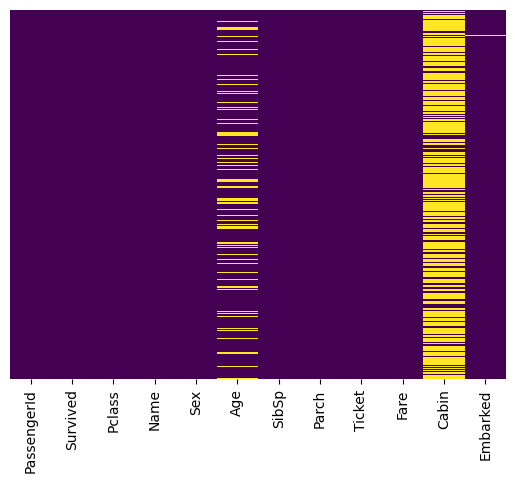

In [11]:
# plot the null values

sns.heatmap(df_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [12]:
df=df_train.copy()

Function to impute missing values 

In [13]:
categorical_cols = ['Cabin', 'Embarked']

numeric_cols = [ 'Age']


missing_data_cols = df.isnull().sum()[df.isnull().sum() > 0].index.tolist()

bool_cols = []  # Define bool_cols to fix the error

# define the function to impute the missing values in thal column

def impute_categorical_missing_data(passed_col):
    
    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    if passed_col in bool_cols:
        y = label_encoder.fit_transform(y)
        
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_classifier = RandomForestClassifier()

    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)

    print("The feature '"+ passed_col+ "' has been imputed with", round((acc_score * 100), 2), "accuracy\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_classifier.predict(X)
        if passed_col in bool_cols:
            df_null[passed_col] = df_null[passed_col].map({0: False, 1: True})
        else:
            pass
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

def impute_continuous_missing_data(passed_col):
    
    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])
    
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_regressor = RandomForestRegressor()

    rf_regressor.fit(X_train, y_train)

    y_pred = rf_regressor.predict(X_test)

    print("MAE =", mean_absolute_error(y_test, y_pred), "\n")
    print("RMSE =", mean_squared_error(y_test, y_pred, squared=False), "\n")
    print("R2 =", r2_score(y_test, y_pred), "\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_regressor.predict(X)
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]





# remove warning
import warnings
warnings.filterwarnings('ignore')

# impute missing values using our functions
for col in missing_data_cols:
    print("Missing Values", col, ":", str(round((df[col].isnull().sum() / len(df)) * 100, 2))+"%")
    if col in categorical_cols:
        df[col] = impute_categorical_missing_data(col)
    elif col in numeric_cols:
        df[col] = impute_continuous_missing_data(col)
    else:
        pass



(df.isnull().sum() / len(df) *100).sort_values(ascending = False)

Missing Values Age : 19.87%
MAE = 9.222488811188812 

RMSE = 11.604135833957523 

R2 = 0.2737167337708728 

Missing Values Cabin : 77.1%
The feature 'Cabin' has been imputed with 29.27 accuracy

Missing Values Embarked : 0.22%
The feature 'Embarked' has been imputed with 89.33 accuracy



PassengerId    0.0
Survived       0.0
Pclass         0.0
Name           0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Ticket         0.0
Fare           0.0
Cabin          0.0
Embarked       0.0
dtype: float64

Missing values have been removed or imputed from the train dataset





In [14]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [15]:
# split the data into X and y
X = df.drop(["Survived", "Name"], axis=1)
y = df["Survived"]

# encode the object and categorical data
label_encoder = LabelEncoder()

for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = label_encoder.fit_transform(X[col])
    else:
        pass

# split the data into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)





In [16]:
X_train.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
331,332,1,1,45.5,0,0,20,28.5000,56,2
733,734,2,1,23.0,0,0,228,13.0000,90,2
382,383,3,1,32.0,0,0,665,7.9250,115,2
704,705,3,1,26.0,1,0,398,7.8542,143,2
813,814,3,0,6.0,4,2,333,31.2750,20,2


## Create a Neural Network (NN) model for binary Classification



In [17]:
# create a neural network, build the model for binary classification, compile the model, train the model, evaluate the model(using mse)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Build the model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32,verbose=1, validation_data=(X_test, y_test))

# Evaluate the model
mse = model.evaluate(X_test, y_test, verbose=0)[0]
print(f'MSE: {mse}')


Epoch 1/100
23/23 [==============================] - 1s 14ms/step - loss: 7.8937 - accuracy: 0.5702 - val_loss: 2.4054 - val_accuracy: 0.6480
Epoch 2/100
23/23 [==============================] - 0s 3ms/step - loss: 2.9034 - accuracy: 0.6081 - val_loss: 1.1757 - val_accuracy: 0.6648
Epoch 3/100
23/23 [==============================] - 0s 4ms/step - loss: 1.6045 - accuracy: 0.6236 - val_loss: 1.1525 - val_accuracy: 0.7095
Epoch 4/100
23/23 [==============================] - 0s 3ms/step - loss: 1.2753 - accuracy: 0.6601 - val_loss: 0.7705 - val_accuracy: 0.6983
Epoch 5/100
23/23 [==============================] - 0s 3ms/step - loss: 0.9099 - accuracy: 0.6699 - val_loss: 0.8030 - val_accuracy: 0.6760
Epoch 6/100
23/23 [==============================] - 0s 5ms/step - loss: 0.8691 - accuracy: 0.6671 - val_loss: 1.2577 - val_accuracy: 0.5363
Epoch 7/100
23/23 [==============================] - 0s 4ms/step - loss: 0.9473 - accuracy: 0.6657 - val_loss: 0.8243 - val_accuracy: 0.6704
Epoch 8/100


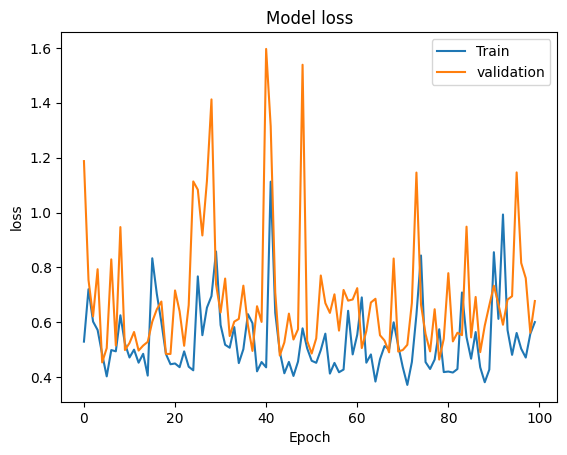

In [18]:
# Assuming the model is already defined and compiled in a previous cell
# If not, please define and compile the model before running this selection

history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_data=(X_test, y_test))

loss = model.evaluate(X_test, y_test, verbose=0)

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(['Train', 'validation'], loc='upper right')
plt.show()